# LT-DSC-Skript


## required libraries 

In [1]:
import os, chardet,matplotlib

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import filedialog
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

## function definitions

In [2]:
def get_brun_pore_radius( delta_T, freeze_melt = 'freeze', ignore_lower_border = False ):
    # Brun et. al 1977; DOI: 10.1016/0040-6031(77)85122-8
    # only valid for water; 0 K > delta_T >= -40 K
    # delta_T = T(current) - T(melting); in K
    pore_radius = np.nan
    if delta_T < 0.01 and (ignore_lower_border or delta_T >= -40): # very low temperatures give exorbitant pore diameters
        if freeze_melt == 'freeze':
            pore_radius = -64.67/delta_T+0.57
        elif freeze_melt == 'melt':
            pore_radius = -32.33/delta_T+0.68
    
    return pore_radius

def load_multiple_experiments(measure_segments, thaw_temp_range):
    root = tk.Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1) # Fenster immer im Vordergrund
    directory = filedialog.askdirectory(title='Bitte das Arbeitsverzeichnis mit den XLS Ergebnis-Dateien der DCA auswählen.')
    directory = directory + os.sep
    root.destroy()
        
    # durchsuche den Ordner nach XLS Dateien
    fileList = []
    for filename in os.listdir( directory ):
        if filename.endswith(".txt"):
            fileList.append(filename)
            
    print('{} TXT Dokumente gefunden.'.format(len(fileList)))
    materials = {}
    for filename in fileList:
        print()
        print(filename)
        experiment = ltdsc_measurement(directory + filename, measure_segments, thaw_temp_range, ignore_first_n_min = 1.25, verbose=False )
        # sort by material
        if not experiment.header['MATERIAL'] in materials.keys():
            materials[experiment.header['MATERIAL']] = {}
        materials[experiment.header['MATERIAL']][experiment.header['IDENTITY']] = experiment
        
    return directory, materials

def process_ice_mass_dev(materials, specimen_ages):
    ice_list_total = []
    ice_list_mean = []
    # iterate through all materials
    for mat, material in materials.items():
        # iterate through the possible specimen ages
        for age in specimen_ages:
            # search the matching experiments with the searched specimen age
            pores_a_mean = []
            pores_b_mean = []
            pores_c_mean = []
            for key, experiment in material.items():
                if '_'+age in key:
                    pores_a_mean.append(experiment.ice_mass[1]-experiment.ice_mass[0])
                    pores_b_mean.append(experiment.ice_mass[0])
                    pores_c_mean.append(experiment.ice_mass[1])
                    pores_a = experiment.ice_mass[1]-experiment.ice_mass[0]
                    pores_b = experiment.ice_mass[0]
                    pores_c = experiment.ice_mass[1]
                    ice_list_total.append([mat, age, pores_a_mean[-1], pores_b_mean[-1], pores_c_mean[-1]])
                    #print(key, experiment.ice_mass)
            if len(pores_a_mean)> 0: ice_list_mean.append([mat, age, np.mean(pores_a_mean), np.mean(pores_b_mean), np.mean(pores_c_mean), np.std(pores_a_mean), np.std(pores_b_mean), np.std(pores_c_mean)])

    ice_dataframe      = pd.DataFrame(ice_list_total, columns=['material', 'age', 'pores_a', 'pores_b', 'pores_c'])
    ice_stat_dataframe = pd.DataFrame(ice_list_mean, columns=['material', 'age', 'pores_a_mean', 'pores_b_mean', 'pores_c_mean', 'pores_a_std', 'pores_b_std', 'pores_c_std'])
    return ice_dataframe, ice_stat_dataframe

def plot_ice_mass_development(mat, ice_stat_dataframe, directory):
    df_s = ice_stat_dataframe[ice_stat_dataframe['material']== mat]
    df_s[["age","pores_a_mean", "pores_b_mean", "pores_c_mean", "pores_a_std", "pores_b_std", "pores_c_std"]].to_csv(directory + '{}_ice_mass_dev.csv'.format(mat))

    x = np.arange(len(df_s))  # the label locations

    fig, ax = plt.subplots(figsize=(10, 5))
    df_s.plot(x="age", y=["pores_a_mean", "pores_b_mean", "pores_c_mean"], kind="bar", ax=ax, capsize=3, yerr=df_s[["pores_a_std", "pores_b_std", "pores_c_std"]].T.values)#, yerr=["pores_a_std", "pores_b_std", "pores_c_std"]
    
    ax.legend(["gel pores", "capillary pores", "total pores"])
    #rects1 = ax.bar(x - width/3, df_s['pores_a_mean'], width, label='gel pores')
    #rects2 = ax.bar(x + width/3, df_s['pores_b_mean'], width, label='capillary pores')
    #rects3 = ax.bar(x + width*2/3, df_s['pores_c_mean'], width, label='total pores')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ice mass cumsum in g/g')
    ax.set_xlabel('')
    ax.set_title('ice mass development of {}'.format(mat))
    ax.set_ylim(0,0.3)
    ax.set_xticks(x)
    ax.set_xticklabels(df_s['age'])
    plt.tight_layout()
    plt.savefig(directory + '{}_ice_mass_dev.svg'.format(mat))
    plt.show()


## main class definition

In [3]:
class ltdsc_measurement:
    n_lines  = 100
    filepath = None
    encoding = 'ISO-8859-1'
    header   = {}
    columns  = []
    segments = [] # start-temp, duration[k/min, time], end-temp
    raw_data = None
    
    thaw_data        = []
    ice_mass         = []
    measure_segments = []
    thaw_temp_range  = []
    values_per_min   = 300
    values_per_s     = 5.0
    
    def guess_encoding( self ):
        with open(self.filepath, 'rb') as input_file:
            rawdata = b''.join([input_file.readline() for _ in range(self.n_lines)])
        self.encoding = chardet.detect(rawdata)['encoding']
        #if self.encoding == 'ISO-8859-1': self.encoding = 'cp1252' # propably ansi
        
    def init_header( self ):
        with open(self.filepath, 'r', encoding=self.encoding) as input_file:
            for i in range(self.n_lines):
                line = next(input_file)
                if line[0] == '#':
                    data = line[1:].split(':')
                    if len(data) > 2: data[1] = data[1] + ':' + data[2] # sometimes the : belongs to a time data
                    label = data[0].strip()
                    self.header[label] = data[1].replace(";", "").strip()
                    if label[0:5] == 'SEG. ':
                        self.header[label] = self.header[label].replace("(K/min)", "")#K.min
                        self.header[label] = self.header[label].replace("°C", "")
                        # process segments
                        self.segments.append( self.header[label].split('/') )
                        self.segments[-1][0] = float(self.segments[-1][0])
                        self.segments[-1][2] = float(self.segments[-1][2])
                        if ':' in self.segments[-1][1]:
                            t = self.segments[-1][1].split(':')
                            duration = timedelta(hours=int(t[0]), minutes=int(t[1]))
                            self.segments[-1][1] = [0.0 , duration]
                        else:
                            val = float(self.segments[-1][1].replace(',', '.'))
                            duration = abs((self.segments[-1][2] - self.segments[-1][0])/val)
                            duration = timedelta(minutes=duration)
                            self.segments[-1][1] = [ val, duration ]
                else:
                    #print("read {} lines of header-info".format(i))
                    break
            line = next(input_file)
            self.columns = line[2:].strip().split(';') # get columns
            
        if 'INSTRUMENT' in self.header.keys() and self.header['INSTRUMENT'] == 'NETZSCH DSC 214':
            self.header['DATE/TIME'] = datetime.strptime(self.header['DATE/TIME'][0:16], '%d.%m.%Y %H:%M')
            print('  Found a valid experiment file. Encoding: {}'.format(self.encoding))
        else:
            assert not ('INSTRUMENT' in self.header.keys() and self.header['INSTRUMENT'] == 'NETZSCH DSC 214'), "Unable to load the file or wrong file type. Assumed the encoding to be {}.".format( self.encoding )

    def load_content( self ):
        self.raw_data = pd.read_csv(self.filepath, delimiter=';', decimal=",", encoding=self.encoding, comment='#', names=self.columns )

        self.values_per_min = ( self.raw_data[self.raw_data['Time/min'] == 1.0].index - self.raw_data[self.raw_data['Time/min'] == 0].index ).values.astype(int)[0] # how many measurements are there per minute
        self.values_per_s   = self.values_per_min/60
        self.raw_data['Temp./K'] = self.raw_data['Temp./°C'] + 273.15
        
        print('  Loading {}'.format(self.header['IDENTITY']))
        print('    - loaded measurement {} from {}'.format(self.header['IDENTITY'], self.header['DATE/TIME']))
        print('    - The data contains {} measurements per s'.format(self.values_per_s) )
          
    def plot_measurement_program( self ):
        assert len(self.header) > 0, "Error: Header not loaded!"
        
        fig, ax = plt.subplots(figsize=(10, 5)) 
        fig.suptitle('measurement program')
        y_val = [self.segments[0][0]]
        x_val = [0]
        x_len = []
        plt_y_max = 40
        plt_y_min = -70
        last_x = 0
        for i, j in enumerate(self.segments):
            y_val.append(j[2])
            x_len.append(j[1][1].total_seconds()/60)
            x_val.append(x_len[-1]+x_val[-1])

            for k, measure_segment in enumerate(self.measure_segments):
                if i+1 >= measure_segment[0] and i+1 <= measure_segment[1]:
                    ax.add_patch(patches.Rectangle(
                                    (x_val[i], plt_y_min), # (x,y)
                                    x_len[i],              # width
                                    plt_y_max-plt_y_min,   # height
                                    alpha = 0.5,
                                    color='green'))
                    break
                    
            ax.vlines(x_val[-1], ymin=plt_y_min, ymax=plt_y_max, color='grey', linestyle='dotted', lw=1)
            
            mid_x = (last_x + x_val[-1])/2
            plt.text(mid_x, 20, (i+1), horizontalalignment='center') # 17.5+(i%2)*4
            last_x = x_val[-1]

        x_val = np.array(x_val)
        y_val = np.array(y_val)
        ax.hlines(0, xmin=0, xmax=x_val.max(), color='grey', linestyle='dotted', lw=1)

        ax.plot(x_val, y_val)
        ax.set_ylim(y_val.min()-5, y_val.max()+5)
        ax.set_xlim(x_val.min(), x_val.max())
        ax.set_xticks(range(0,int(x_val.max()),30))
        ax.set_ylabel('temperature in °C')
        ax.set_xlabel('time in min')
        plt.tight_layout()
        plt.show()

    def plot_selected_segments( self ):    
        fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
        fig.suptitle('raw data from the selected segments') 
        for k, measure_segment in enumerate(self.measure_segments):
            df_s = self.raw_data[(self.raw_data['Segment'] >= measure_segment[0]) & (self.raw_data['Segment'] <= measure_segment[1])].copy()
            #print(df_s['Time/min'].min())
            df_s['Time/min'] -= df_s['Time/min'].min()

            df_s.plot(x='Time/min', y='DSC/(mW/mg)', label="Segments {}-{}".format(measure_segment[0], measure_segment[1]), ax=ax[0])
            df_s.plot(x='Temp./°C', y='DSC/(mW/mg)', label="Segments {}-{}".format(measure_segment[0], measure_segment[1]), ax=ax[1])
            
            #print arrow heads to indicate the measurement-direction
            last_color = plt.gca().lines[-1].get_color()
            for j in [1,2,3,4,5]:
                idx0 = int(len(df_s)*j/6)
                idx1 = idx0+10
                x  = df_s.iloc[idx0, df_s.columns.get_loc('Temp./°C')]
                y  = df_s.iloc[idx0, df_s.columns.get_loc('DSC/(mW/mg)')]
                x1 = df_s.iloc[idx1, df_s.columns.get_loc('Temp./°C')]
                y1 = df_s.iloc[idx1, df_s.columns.get_loc('DSC/(mW/mg)')]
                ax[1].arrow(x, y, x1-x, y1-y, shape='full', lw=0, length_includes_head=False, head_width=.03, head_length=1.0, color=last_color)

        ax[0].set_xlim(0, df_s['Time/min'].max())
        ax[0].set_ylabel('DSC in W/g')
        ax[0].set_xlabel('time in min')
        ax[0].grid(True)
        
        ax[1].set_ylabel('DSC in W/g')
        ax[1].set_xlabel('temperature in °C')
        ax[1].grid(True)
        
        plt.tight_layout()
        plt.show()

    def base_line_correction( self, ignore_first_n_min = 1.25, plot = False ):
        model = LinearRegression()
        if plot: fig, ax = plt.subplots(ncols=4, figsize=(20, 5)) 
        for k, measure_segment in enumerate(self.measure_segments):
            df_s = self.raw_data[(self.raw_data['Segment'] == measure_segment[1])].copy()
            df_s['Time/min'] -= df_s['Time/min'].min()
            
            # plot raw data
            if plot: 
                df_s.plot(x='Time/min', y='DSC/(mW/mg)', label="Segment {} raw".format(measure_segment[1]), ax=ax[1])
                df_s.plot(x='Time/min', y='DSC/(mW/mg)', label="Segment {} raw".format(measure_segment[1]), ax=ax[2])
            
            df_s = df_s[df_s['Time/min'] >= ignore_first_n_min].copy()
            
            df_s['DSC/(mW/mg) diff'] = df_s['DSC/(mW/mg)'].rolling(window=int(.5*self.values_per_min)).mean().diff() # smooth the raw data and differentiate the data
            df_s['DSC/(mW/mg) smooth'] = df_s['DSC/(mW/mg) diff'].rolling(window=int(.5*self.values_per_min)).mean()  # smooth the differentiated data again
            
            df_s2 = df_s[(df_s['DSC/(mW/mg) smooth'] < 0.000004) & (df_s['DSC/(mW/mg) smooth'] > -0.000001) & (df_s['DSC/(mW/mg)'].abs() < 0.1)].copy() #0.000000025]
            
            x = df_s2[['Time/min']]
            y = df_s2['DSC/(mW/mg)']
            model.fit(x, y)
            r2_score = model.score(x, y)
            print('  Segment {} baseline: y = {:.8f}*x + {:.8f}; R-squared value: {:.8f}'.format(measure_segment[1], model.coef_[0], model.intercept_, r2_score))
            
            # correct the DSC curves by substracting the baseline
            df_s['DSC/(mW/mg) corr'] = df_s['DSC/(mW/mg)']-model.predict(df_s[['Time/min']])
            
            # calculate melting enthalpy for every point
            T_melt_ice = 273.15
            delta_T = df_s['Temp./K']-T_melt_ice
            df_s['melting enthalpy/(J/g)'] = 334.1 + 2.119*delta_T - 0.00783*delta_T**2 # Gleichung von Randall https://doi.org/10.1016/0040-6031(94)02174-M / Diss Matthias, Seite 62

            self.thaw_data.append(df_s)
            print( os.path.dirname(self.filepath) + os.sep + '{}_melt_segment_{}.csv'.format( self.filename, measure_segment[1] ) )
            df_s.iloc[::int(self.values_per_s)].to_csv( os.path.dirname(self.filepath) + os.sep + '{}_melt_segment_{}.csv'.format( self.filename, measure_segment[1] ) )
            
            # plot some curves
            if plot: 
                df_s2.plot(x='Time/min', y='DSC/(mW/mg) smooth',     label="Segment {}".format(        measure_segment[1]), ax=ax[0])
                df_s2.plot(x='Temp./K',  y='DSC/(mW/mg)',            label="Segment {} to-fit".format( measure_segment[1]), ax=ax[1])
                ax[1].plot(x, model.predict(x), color='grey', linewidth=1)
                df_s.plot( x='Time/min', y='DSC/(mW/mg) corr',       label="Segment {} corr.".format(  measure_segment[1]), ax=ax[2])
                df_s.plot( x='Time/min', y='melting enthalpy/(J/g)', label="Segment {}".format(        measure_segment[1]), ax=ax[3])
            
        if plot:
            ax[0].set_title('diff+smooth')
            ax[1].set_title('baseline correction')
            ax[1].set_ylim(0.0,0.1)
            ax[2].set_title('corrected raw data')
            ax[3].set_title('melting enthalpy')
            #plt.ylim(0,0.1)
            #plt.xlim(0,30)
            for i in range(4):
                ax[i].set_xlim(0, df_s['Time/min'].max())
                ax[i].set_xlabel('time in min')
                ax[i].set_ylabel('DSC in W/g')
            plt.tight_layout()
            plt.show()

    def delta_brun_pore_radius(self, segment_id, delta_T, ignore_lower_border = False):
        segment_id = int(segment_id)
        delta = self.segments[segment_id-1][2]-self.segments[segment_id-1][0]
        freeze_melt = 'freeze' if (delta < 0) else 'melt' if (delta > 0) else 'undefined'
        rp = get_brun_pore_radius( delta_T, freeze_melt, ignore_lower_border )
        #print(delta_T, freeze_melt, rp)
        return rp
        
    def guess_pore_radius(self):
        self.raw_data['pore radius in nm'] = self.raw_data.apply(
            lambda row:  self.delta_brun_pore_radius( row['Segment'], row['Temp./°C'], ignore_lower_border = True ),
            axis=1 # this returns a single row
        )
        
    def get_ice_mass( self, plot = False ):
        if plot: fig, ax = plt.subplots(ncols=2, figsize=(15, 5)) 
        for i, measure_segment in enumerate(self.measure_segments):
            self.thaw_data[i]['ice mass/(mg/g)'] = (self.thaw_data[i]['DSC/(mW/mg) corr']/self.values_per_s)*1000/self.thaw_data[i]['melting enthalpy/(J/g)']
            

            df_s = self.thaw_data[i][(self.thaw_data[i]['Temp./°C'] >= self.thaw_temp_range[i][0]) & (self.thaw_data[i]['Temp./°C'] <= self.thaw_temp_range[i][1])].copy()
            df_s['ice mass cumsum/(g/g)'] = df_s['ice mass/(mg/g)'].cumsum()/1000
            self.ice_mass.append( df_s['ice mass cumsum/(g/g)'].max() )
            print('  ice mass in segment {} between {} and {} °C: {:.1f} mg/g'.format(measure_segment[1], self.thaw_temp_range[i][0], self.thaw_temp_range[i][1], self.ice_mass[i]*1000))
            
            if plot:
                self.thaw_data[i].plot(x='Temp./°C', y='ice mass/(mg/g)',          ax=ax[0], label="segment {}".format( measure_segment[1] ))
                df_s.plot(             x='Temp./°C', y='ice mass cumsum/(g/g)',    ax=ax[1], label="segment {}".format( measure_segment[1] ))
                #df_s.plot(             x='pore radius in nm', y='ice mass/(mg/g)', ax=ax[2], label="segment {}".format( measure_segment[1] ))
                #df_s.plot(             x='pore radius in nm', y='ice mass cumsum/(g/g)', ax=ax[2], label="segment {} cs".format( measure_segment[1] ))
                #print(df_s[['pore radius in nm', 'ice mass/(mg/g)']])
         
        if plot: 
            ax[0].set_title('differential ice mass')
            ax[0].set_xlabel('temperature in °C')
            ax[0].set_ylabel('ice mass in mg/g')
            
            ax[1].set_title('cumulative ice mass')
            ax[1].set_xlabel('temperature in °C')
            ax[1].set_ylabel('ice mass cumsum in g/g')
            
            """ax[2].set_title('differential ice mass / pore radius')
            ax[2].set_xlabel('pore radius in nm')
            ax[2].set_ylabel('ice mass in mg/g')
            ax[2].set_xlim(0,1000)"""
            plt.tight_layout()
            plt.show()
            
        print('  ice mass difference: {:.2f} mg/g'.format((self.ice_mass[1]-self.ice_mass[0])*1000))

    def plot_pore_heat( self, plot = False ):
        if plot: fig, ax = plt.subplots(ncols=2, figsize=(15, 5)) 
        for k, measure_segment in enumerate(self.measure_segments):
            for i in [0,1]:
                df_s = self.raw_data[(self.raw_data['Segment'] == measure_segment[0])]
                
                df_s.iloc[::int(self.values_per_s)].to_csv( os.path.dirname(self.filepath) + os.sep + '{}_freeze_segment_{}.csv'.format( self.filename, measure_segment[0] ) )
                if plot:
                    df_s.plot(             y='DSC/(mW/mg)', x ='pore radius in nm', ax=ax[i], label="segment {}".format( measure_segment[0] ))
                    ax[i].set_ylim(0.03,-.2)
                    ax[i].set_xlabel('pore radius in nm')
                    ax[i].set_ylabel('DSC in W/g')
            if plot:
                ax[0].set_xscale('log')
                ax[0].set_xticks([1,2.5,5,10,25,50])
                ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        if plot:
            plt.tight_layout()
            plt.show()
        
    def __init__( self, filepath, measure_segments, thaw_temp_range, ignore_first_n_min = 1.25, verbose = False ):
        self.filepath         = filepath
        self.filename         = os.path.splitext(os.path.basename(filepath))[0]
        self.measure_segments = measure_segments
        self.thaw_temp_range  = thaw_temp_range
        self.segments  = []
        self.columns   = []
        self.thaw_data = []
        self.ice_mass  = []
        self.guess_encoding()           # try to detect the encoding
        self.init_header()              # load the header of the file
        self.load_content()
        
        if verbose: 
            self.plot_measurement_program() # plot the segments / measurement program
            self.plot_selected_segments()
        
        self.guess_pore_radius()
        self.base_line_correction( ignore_first_n_min, plot = verbose )
        self.get_ice_mass(   plot = verbose )
        self.plot_pore_heat( plot = verbose )
        

Wähle manuell die relevanten Segmentpositionen aus in Form einer Liste. Z.B für Segment 6-8 und 14-16:

`measure_segments = [[6,8],[14,16]]`

In [4]:
measure_segments =  [ [6,8],
                      [14,16] ]

thaw_temp_range  =  [ [-16, 10], 
                      [-57, 10] ] # in °C

## select a single measurement

In [5]:
# Öffnet den Datei-auswählen Dialog und speichert den ausgewählten Ordner
root = tk.Tk()
root.withdraw()
root.wm_attributes('-topmost', 1) # Fenster immer im Vordergrund
file = filedialog.askopenfilename(title='Bitte die Messung auswählen.')
root.destroy()

  Found a valid experiment file. Encoding: ISO-8859-1
  Loading C3S 21d-1
    - loaded measurement C3S 21d-1 from 2024-11-19 08:07:00
    - The data contains 5.0 measurements per s


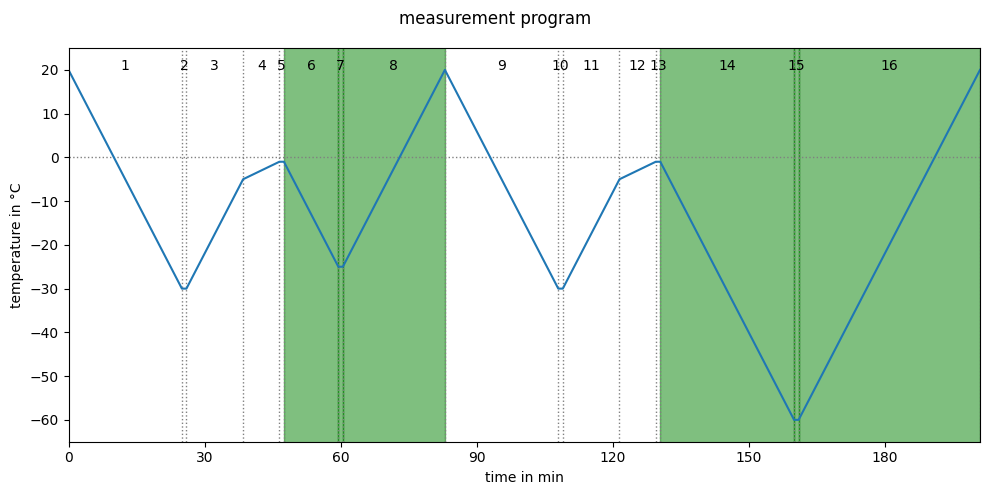

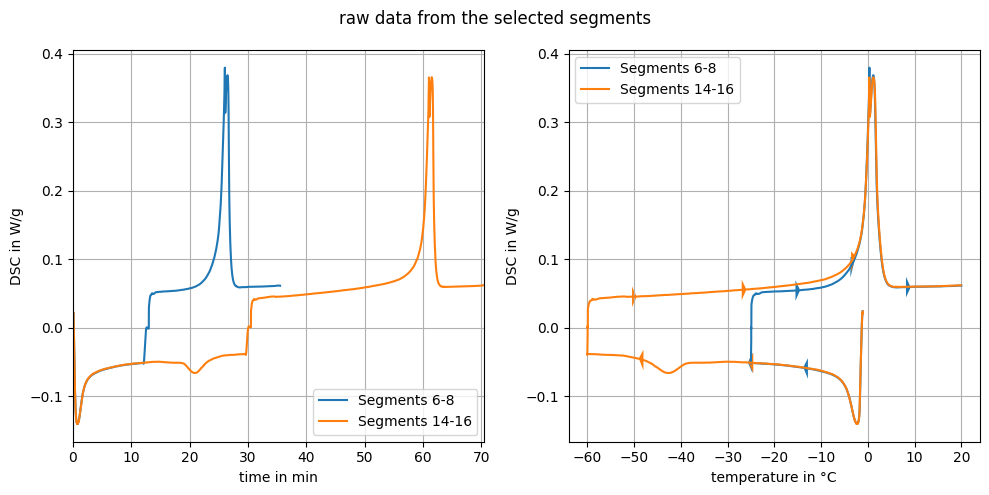

  Segment 8 baseline: y = 0.00041353*x + 0.05211303; R-squared value: 0.98767689
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\ExpDat_C3S_21d-1_melt_segment_8.csv
  Segment 16 baseline: y = 0.00043730*x + 0.04513827; R-squared value: 0.89764334
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\ExpDat_C3S_21d-1_melt_segment_16.csv


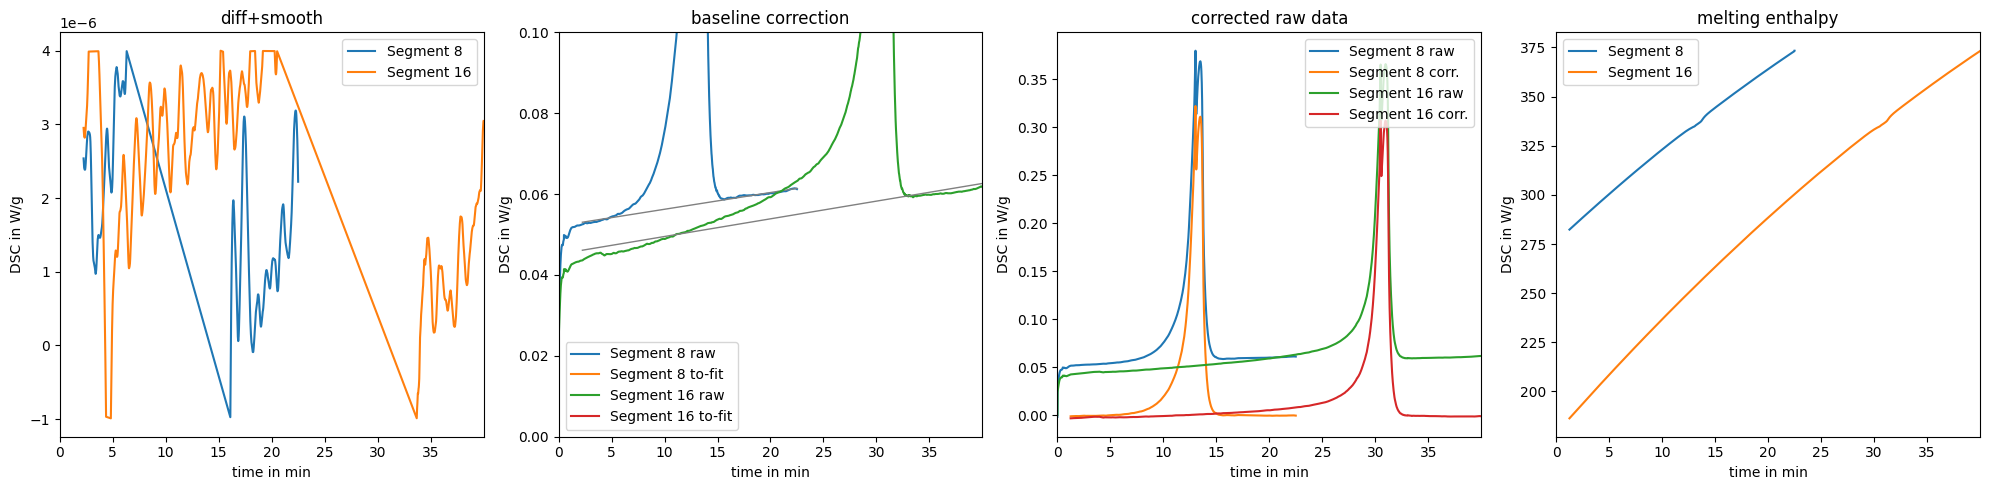

  ice mass in segment 8 between -16 and 10 °C: 96.1 mg/g
  ice mass in segment 16 between -57 and 10 °C: 110.3 mg/g


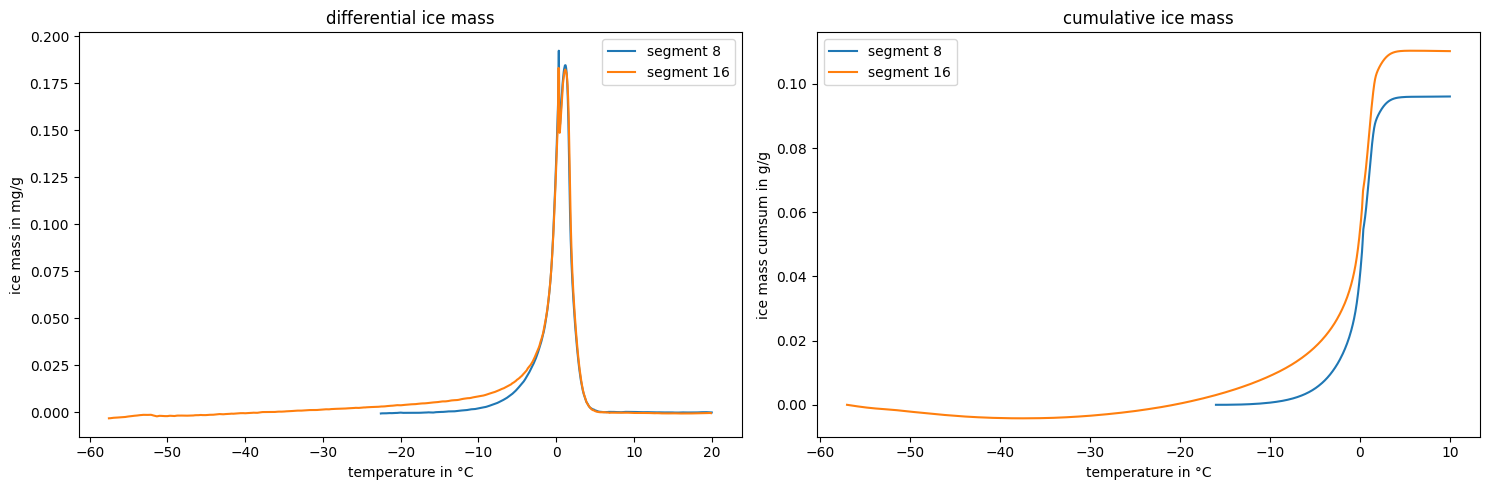

  ice mass difference: 14.26 mg/g


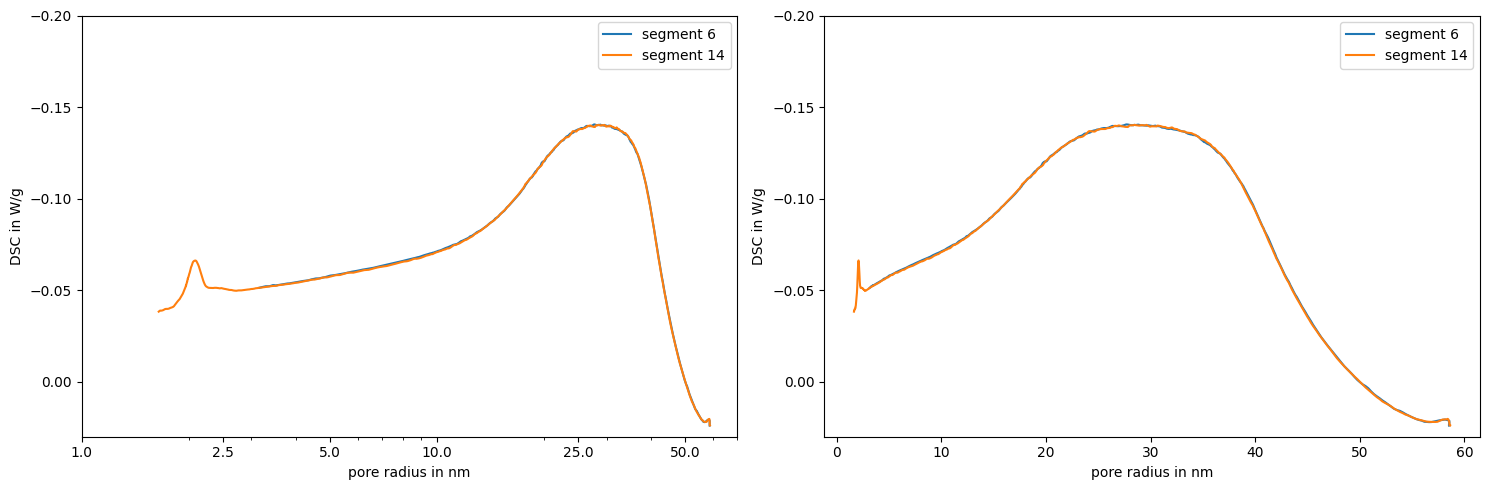

In [6]:
experiment = ltdsc_measurement(file, measure_segments, thaw_temp_range, ignore_first_n_min = 1.25, verbose=True)

## The following code is individual for the selected dataset

27 TXT Dokumente gefunden.

ExpDat_C2S_14d-1.txt
  Found a valid experiment file. Encoding: ISO-8859-1
  Loading C2S_14d-1
    - loaded measurement C2S_14d-1 from 2024-11-21 07:59:00
    - The data contains 5.0 measurements per s
  Segment 8 baseline: y = 0.00098506*x + 0.04837453; R-squared value: 0.98600773
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\ExpDat_C2S_14d-1_melt_segment_8.csv
  Segment 16 baseline: y = 0.00078965*x + 0.03832429; R-squared value: 0.98958852
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\ExpDat_C2S_14d-1_melt_segment_16.csv
  ice mass in segment 8 between -16 and 10 °C: 240.4 mg/g
  ice mass in segment 16 between -57 and 10 °C: 252.6 mg/g
  ice mass difference: 12.13 mg/g

ExpDat_C2S_14d-2.txt
  Found a valid experiment file. Encoding: ISO-8859-1
  Loading C2S_14d-2
    - loaded measurement C2S_14d-2 from 2024-11-21 11:30:00
    - The data contains 5.0 measure

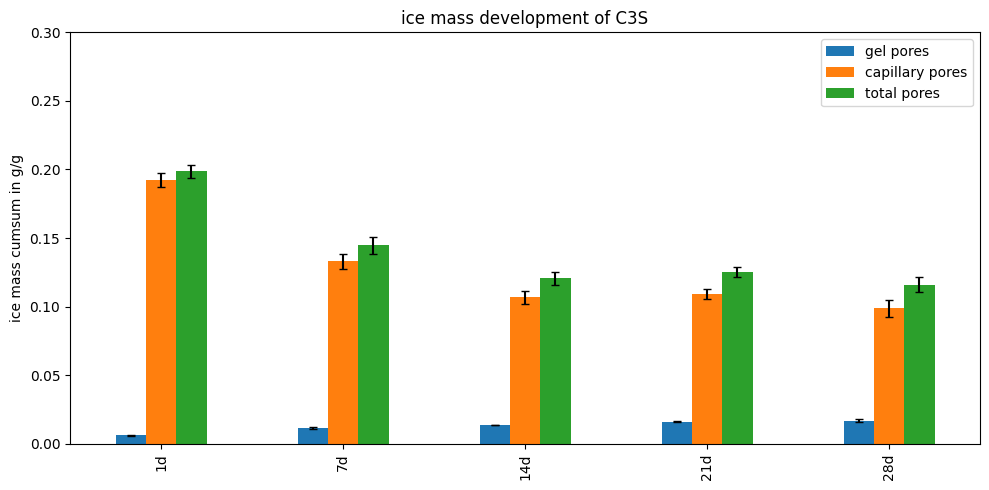

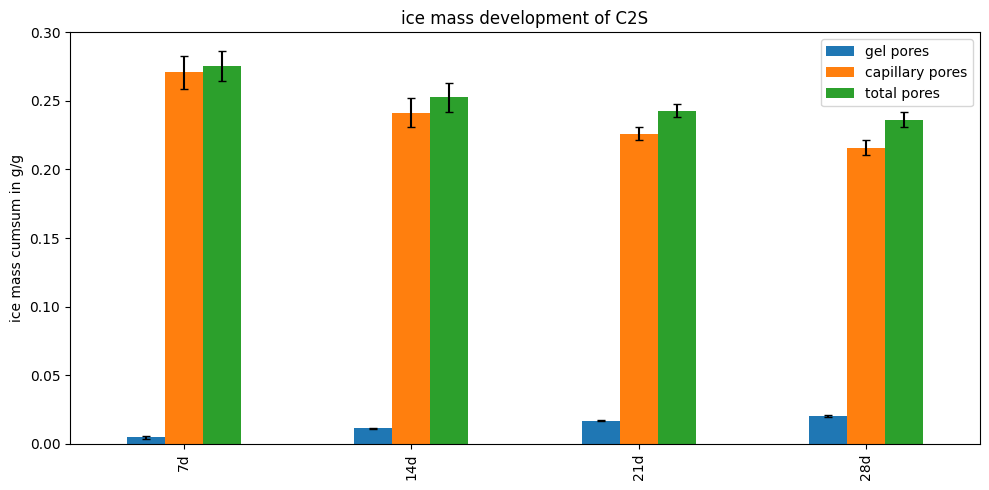

In [7]:
directory, materials = load_multiple_experiments( measure_segments, thaw_temp_range )
specimen_ages = ['1d','7d','14d','21d','28d']
ice_dataframe, ice_stat_dataframe = process_ice_mass_dev( materials, specimen_ages )
    
plot_ice_mass_development('C3S', ice_stat_dataframe, directory )
plot_ice_mass_development('C2S', ice_stat_dataframe, directory )